# L1b to L1c processing
Applies Sigma0 calibration from Star Pattern data 

In [1]:
import xarray as xr
import numpy as np
import scipy as sp
import seastar as ss
import warnings
import os
from _version import __version__
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion as erode

In [2]:
version='v20230411'
save_folder=os.path.join('D:\data\SEASTAR\SEASTARex\Data\L1c','')
#days = ['17','22','25','26']
days = ['17', '22', '25', '26']
flights = ['202205' + d for d in days]
file_paths = ss.utils.readers._set_file_paths()
file_paths['l1b_path'] = "D:\\data\\SEASTAR\\SEASTARex\\Data\\L1b\\"
L1b_path = os.path.join(file_paths['l1b_path'],'')
DAR_tracks = dict()
DAR_tracks['20220517'] = {
    'Track_11': 0,
    'Track_12': 1,
    'Track_13': 2,
    'Track_2': 3,
    'Track_1': 4,
    'Track_1b': 5,
    'Track_L1': 6,
}
DAR_tracks['20220522'] = {
    'Track_1': 0,
    'Track_2': 1,
    'Track_1b': 2,
    'Track_11': 3,
    'Track_12': 4,
    'Track_13': 5,
    'Track_14': 6,
    'Track_15': 7,
    'Track_16': 8,
    'Track_17': 9,
    'Track_18': 10,
    'Track_2b': 11,
    'Track_L1': 12,
}
DAR_tracks['20220525'] = {
    'Track_L1': 0,
    'Track_22a1': 1,
    'Track_22a2': 2,
    'Track_22a3': 3,
    'Track_22a4': 4,
    'Track_22a5': 5,
    'Track_22b': 6,
}
DAR_tracks['20220526'] = {
    'Track_2': 0,
    'Track_1': 1,
    'Track_13': 2,
    'Track_14': 3,
    'Track_11': 4,
    'Track_12': 5,
    'Track_17': 6,
    'Track_18': 7,
    'Track_15': 8,
    'Track_16': 9,
    'Track_2b': 10,
    'Track_1b': 11,
    'Track_L1': 12,
}

Device name = LIVPCZG-10
Setting local paths...


# Load Sigma0 bias data
Bias data takes the form of curve fitting parameters using the fit function below. Output is a bias in dB
from the NSCAT4DS model

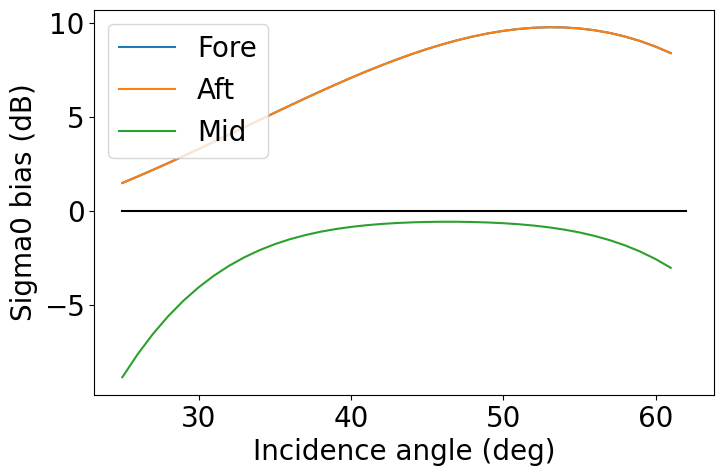

In [3]:
sigma0_bias = xr.open_dataset('D:\\data\\SEASTAR\\SEASTARex\\Data\\calib\\sigma0_bias.nc')
def sigma0_func(az, A, B, C, f):
    g = A * (
            1\
            + np.sign(A)*B*np.cos(np.radians(az-f))\
            + np.sign(A)*C*np.cos(np.radians(2*(az-f)))
        )
    return(g.ravel())
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)   
plt.rc('legend', fontsize=20) 
inc = np.arange(25,62)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,1,1)
for ant in ['Fore','Aft','Mid']:
    plt.plot(inc,sigma0_func(inc,*sigma0_bias.bias.sel(Antenna=ant).data), label=ant)
plt.plot([25,62],[0,0],'k')
plt.xlabel('Incidence angle (deg)', fontsize=20)
plt.ylabel('Sigma0 bias (dB)', fontsize=20)
plt.legend(loc='upper left')

# Load phase bias data
Bias takes the form of curve fitting parameters using the fit function below. Output is a phase bias in radians for each
of the squinted channels

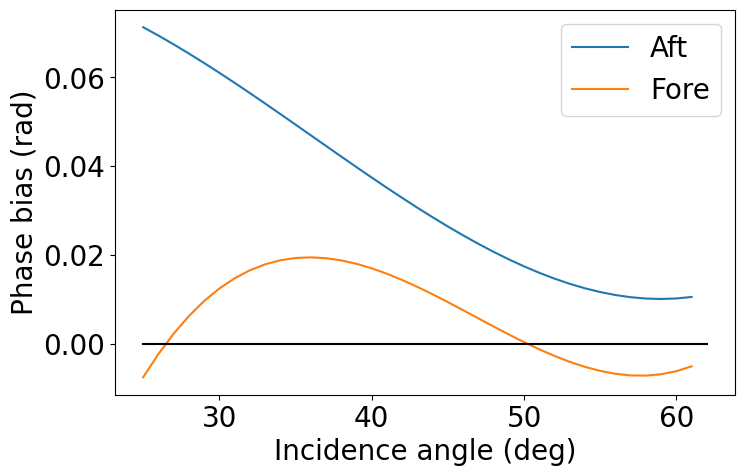

In [4]:
phase_bias = xr.open_dataset('D:\\data\\SEASTAR\\SEASTARex\\Data\\calib\\phase_calib.nc')
def phase_func(x, a, b, c, d):
    g = (a*x**3) + (b*x**2) + (c*x) + d
    return (g.ravel())
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)   
plt.rc('legend', fontsize=20) 
inc = np.arange(25,62)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,1,1)
for ant in ['Aft','Fore']:
    plt.plot(inc,phase_func(inc,*phase_bias.bias.sel(Antenna=ant).data), label=ant)
plt.plot([25,62],[0,0],'k')
plt.xlabel('Incidence angle (deg)', fontsize=20)
plt.ylabel('Phase bias (rad)', fontsize=20)
plt.legend(loc='upper right')

In [5]:
# for flight in ['20220517', '20220522']:
for flight in flights:
    print('Processing flight ', flight, '...')
    DAR_list=DAR_tracks[flight]
#     for track in ['Track_2']:
    for track in DAR_list.keys():
        print('Processing track',track,'...')
        ds_L1b = xr.open_dataset(file_paths['l1b_path'] + flight + '_' + track + '_OSCAR_L1b.nc')
        ds_L1c = ds_L1b.copy(deep=True)
        
        # Radiometric calibration
        Sigma0 = [ss.utils.tools.lin2db(ds_L1b.Intensity.sel(Antenna=ant)) -
                 np.reshape(sigma0_func(ds_L1b.IncidenceAngleImage.sel(Antenna=ant).data,
                                            *sigma0_bias.bias.sel(Antenna=ant).data,
                                           ),
                            ds_L1b.Intensity.sel(Antenna=ant).shape,
                            ) 
                  for ant in ds_L1b.Antenna]
        ds_L1c['Sigma0'] = ss.utils.tools.db2lin(xr.concat(Sigma0, dim='Antenna', join='outer'))
        ds_L1c['Sigma0'].attrs['long_name'] = 'Sigma0'
        ds_L1c['Sigma0'].attrs['units'] = ''
        ds_L1c['Sigma0'].attrs['description'] = 'Calibrated NESZ using NSCAT4DS and over-ocean OSCAR data'
        
        # Interferometric phase calibration
        for ant in ['Fore','Aft']:
            ds_L1c['Interferogram'].loc[dict(Antenna=ant)] = (ds_L1b.Interferogram.sel(Antenna=ant)\
                            - np.reshape(phase_func(ds_L1b.IncidenceAngleImage.sel(Antenna=ant).data,
                                                    *phase_bias.bias.sel(Antenna=ant).data,
                                                   ),
                                         ds_L1b.Interferogram.sel(Antenna=ant).shape,
                                        )
                                                             )
            ds_L1c['Interferogram'].attrs['description'] =\
            'Interferometric phase calibrated using over-ocean OSCAR data'
        rsv = [ss.oscar.level1.compute_radial_surface_velocity(ds_L1c.sel(Antenna=ant))
               for ant in ds_L1c.Antenna.values]
        ds_L1c['RadialSurfaceVelocity'] = xr.concat(rsv, 'Antenna',join='outer')
        
        # Removing erroneous edge pixels from RSV
        mask = ds_L1c.IncidenceAngleImage > 0
        for ant in mask.Antenna:
            mask.loc[dict(Antenna=ant)] = erode(mask.sel(Antenna=ant), iterations=2)
            ds_L1c['RadialSurfaceVelocity'].loc[dict(Antenna=ant)] =\
                xr.where(mask.sel(Antenna=ant),
                         ds_L1c.RadialSurfaceVelocity.sel(Antenna=ant),
                         np.NaN,
                        )
            ds_L1c['Sigma0'].loc[dict(Antenna=ant)] =\
                xr.where(mask.sel(Antenna=ant),
                         ds_L1c.Sigma0.sel(Antenna=ant),
                         np.NaN,
                        )
            ds_L1c['IncidenceAngleImage'].loc[dict(Antenna=ant)] =\
                xr.where(mask.sel(Antenna=ant),
                         ds_L1c.IncidenceAngleImage.sel(Antenna=ant),
                         np.NaN,
                        )
            
        ds_L1c.attrs['Codebase'] = 'seastar_project'
        ds_L1c.attrs['Repository'] = 'https://github.com/NOC-EO/seastar_project'
        ds_L1c.attrs['Code_version'] = __version__
        ds_L1c.attrs['Data_version'] = version
        ds_L1c.attrs['Comments'] = 'Processed on ' + datetime.today().strftime('%Y%m%d')
        print('Saving to disk...')
        ds_L1c.to_netcdf(os.path.join(save_folder, flight + '_' + track +'_OSCAR_L1c.nc'))

Processing flight  20220517 ...
Processing track Track_11 ...
Saving to disk...
Processing track Track_12 ...
Saving to disk...
Processing track Track_13 ...
Saving to disk...
Processing track Track_2 ...
Saving to disk...
Processing track Track_1 ...
Saving to disk...
Processing track Track_1b ...
Saving to disk...
Processing track Track_L1 ...
Saving to disk...
Processing flight  20220522 ...
Processing track Track_1 ...
Saving to disk...
Processing track Track_2 ...
Saving to disk...
Processing track Track_1b ...
Saving to disk...
Processing track Track_11 ...
Saving to disk...
Processing track Track_12 ...
Saving to disk...
Processing track Track_13 ...
Saving to disk...
Processing track Track_14 ...
Saving to disk...
Processing track Track_15 ...
Saving to disk...
Processing track Track_16 ...
Saving to disk...
Processing track Track_17 ...
Saving to disk...
Processing track Track_18 ...
Saving to disk...
Processing track Track_2b ...
Saving to disk...
Processing track Track_L1 ..